In [130]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import chi2
from math import floor
from math import ceil
from sklearn.svm import LinearSVC
import operator
from functools import reduce
import itertools
import random
import os
import time
import copy
from Utilities import G2Dependency

In [29]:
class RandomWalk():
    
    def __init__(self, alpha, delta, max_neighbours):
        
        self._frec_matrix = None
        self._restricted_frec_matrix = None
        self._dep_matrix = None
        self._G2Dep = None
        
        
        self._data_frame = None
        self._data_c_size = -1
        self._alpha = alpha
        self._delta = delta
        self._max_neighbours = max_neighbours
        
        self._target_node = "None"
        
        print("Random Walk successful instantiation with:")
        print("-Alpha: "+str(self._alpha))
        print("-Delta: "+str(self._delta))
        print("-Max Neighbours per run: "+str(self._max_neighbours))
        
        return
    
    def _get_dep_matrix(self):
        return self._dep_matrix
    
    def get_G2Dep(self):
        return self._G2Dep
    
    def set_alpha(self, alpha):
        self._alpha = alpha
        print("Succesfully set an alpha of: "+str(self._alpha))
        
        return
    
    def set_min_threshold(self, delta):
        self._delta = delta
        print("Succesfully set an minimum threshold of: "+str(self._delta))
        
        return
    
    def set_max_neighbours(self, m_n):
        self._max_neighbours = m_n
        print("Succesfully set an maximum number of neighbours of: "+str(self._max_neighbours))
        return

In [30]:
class RandomWalk(RandomWalk):
    
    def fit(self,X):
        
        """
        Pre-process dataframe in order to process it
        """
        x_heads = []
        for i in range(0,len(X.keys())):
            max_v=1
            for row in X[X.keys()[i]]:
                if (row>max_v-1):
                    max_v+=row-(max_v-1)
            x_heads.append("Node"+str(i+1)+"@"+str(max_v))
        X.columns = x_heads
        self._data_c_size = X.shape[0]
        self._data_frame = self.__arrayX(X)
        
        
        """
        Process all nodes to fill the dep_matrix
        """
        
        dep_matrix = {}
        frec_matrix = {}
        # intialize matrices
        for column in self._data_frame:
            dep_matrix[column['name'].split('@')[0]] = {}
            frec_matrix[column['name'].split('@')[0]] = {}
            for sub_column in self._data_frame:
                dep_matrix[column['name'].split('@')[0]][sub_column['name'].split('@')[0]] = -1
                frec_matrix[column['name'].split('@')[0]][sub_column['name'].split('@')[0]] = 0
        
        # fill and pop dict.keys
        self._G2Dep = G2Dependency(self._alpha, self._data_c_size)
        
        for column in self._data_frame:
            for sub_column in self._data_frame:
                c_name = column['name'].split('@')[0]
                sub_c_name = sub_column['name'].split('@')[0]
                
                if c_name == sub_c_name:
                    continue
                if c_name not in dep_matrix.keys():
                    continue
                if sub_c_name not in dep_matrix[column['name'].split('@')[0]].keys():
                    continue
                if dep_matrix[c_name][sub_c_name]>-1:
                    continue
                
                
                dep_result, dep_effective = self._G2Dep.dependency(column,sub_column,[],0.05) # 20200903
                if (dep_result < self._delta):
                    # pop the entry from both sides
                    del dep_matrix[c_name][sub_c_name]
                    del dep_matrix[sub_c_name][c_name]
                    del frec_matrix[c_name][sub_c_name]
                    del frec_matrix[sub_c_name][c_name]
                    continue
                    
                dep_matrix[c_name][sub_c_name] = dep_result
                dep_matrix[sub_c_name][c_name] = dep_result
                
        
        # Saving the dep_matrix
        self._dep_matrix = dep_matrix
        self._frec_matrix = frec_matrix
        
        """
        Message of confirmation
        """
        
        print("Succesfully fitted array of "+str(len(X.keys()))+" columns")
        print("and "+str(self._data_c_size)+" rows per column.")
        
        return
    
    def __arrayX(self,X):
        returnable=[]
        for key in X:
            append_dict={'name':key,'data':X[key].copy(deep=True).tolist()}
            returnable.append(append_dict)
        return returnable

In [31]:
class RandomWalk(RandomWalk):
    
    def evaluate_node_index(self, main_index, num_iter):
        
        # we will reset first the frecuency matrix
        self.__reset_frec_matrix()
        
        main_n = 'Node' + str(main_index + 1)
        
        for iter_n in range(0, num_iter):
            # initialize visited vector
            curr_n = main_n
            visited_nodes = [main_n]
            n_jumps = 0
            while (curr_n != -1 and n_jumps < self._max_neighbours):
                # mark step
                if (curr_n != main_n):
                    visited_nodes.append(curr_n)
                
                curr_n = self.__jump(curr_n, visited_nodes)
                n_jumps += 1
        
        
        return self._frec_matrix
    
    
    def __jump(self, origin_n, visited_nodes):
        possible_nodes = [x for x in self._frec_matrix[origin_n] 
                          if x not in visited_nodes]
        if (len(possible_nodes) == 0):
            return -1
        
        max_val = reduce(operator.add, [self._dep_matrix[origin_n][x] 
                                        for x in possible_nodes])
        
        jump_result = np.random.uniform(0,max_val,1)[0]
        
        accumulator = 0
        for x in possible_nodes:
            next_val = self._dep_matrix[origin_n][x]
            if (accumulator + next_val > jump_result):
                self._frec_matrix[origin_n][x] += 1
                return x
            accumulator += next_val
        
        return -1
        
        
        
    
    def __reset_frec_matrix(self):
        for key in self._frec_matrix:
            for sub_key in self._frec_matrix[key]:
                self._frec_matrix[key][sub_key] = 0
        
        return
        

In [126]:
df = pd.read_csv("/home/sdelrio/alarm_datasets/Alarm10/Alarm10_s5000_v3.txt",delimiter='  ',header=None, engine='python')

In [58]:
c_inst = RandomWalk(0.05,0.1,1)

Random Walk successful instantiation with:
-Alpha: 0.05
-Delta: 0.1
-Max Neighbours per run: 1


In [127]:
#%%time
c_inst.fit(df)

Succesful instantiation of Dep object
Succesfully fitted array of 370 columns
and 5000 rows per column.


In [ ]:
dep_mm = c_inst._get_dep_matrix()

In [ ]:
dep_mm['Node101']

In [128]:
#%%time
t_node_index = 12
n_iter = 10000
evaluation = c_inst.evaluate_node_index(t_node_index,n_iter)

CPU times: user 332 ms, sys: 0 ns, total: 332 ms
Wall time: 920 ms


In [129]:
threshold = 5
results=sorted(evaluation["Node"+str(t_node_index+1)].items(), key=lambda x:x[1], reverse=True)[:threshold]
print(results)
print([x[0] for x in results])

[('Node187', 310), ('Node19', 306), ('Node31', 299), ('Node28', 298), ('Node15', 289)]
['Node187', 'Node19', 'Node31', 'Node28', 'Node15']


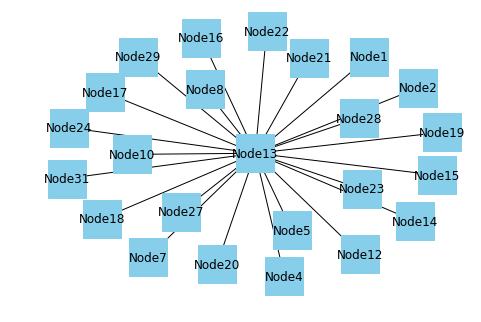

In [85]:
# #%matplotlib inline
# import networkx as nx
# graph_df = pd.DataFrame(columns=['from','to'])
# for x in evaluation:
#     for y in evaluation[x]:
#         if evaluation[x][y] > 0:
#             graph_df = graph_df.append({'from':x,
#                                      'to':y},ignore_index=True)


# import matplotlib.pyplot as plt
# G = nx.from_pandas_edgelist(graph_df, 'from', 'to')
# nx.draw(G, with_labels=True, node_size=1500,width=1, linewidths=1, node_color="skyblue", style='solid', node_shape="s")
# plt.show()

In [83]:
for x in evaluation:
    for y in evaluation["Node"+str(t_node_index+1)]:
        if x=="Node"+(str(t_node_index+1)):
            print("Link from "+x+" to "+y+" had the strength of: "+str(evaluation[x][y])+"/"+str(n_iter))

Link from Node12 to Node1 had the strength of: 341/10000
Link from Node12 to Node2 had the strength of: 395/10000
Link from Node12 to Node4 had the strength of: 368/10000
Link from Node12 to Node5 had the strength of: 356/10000
Link from Node12 to Node7 had the strength of: 377/10000
Link from Node12 to Node8 had the strength of: 378/10000
Link from Node12 to Node10 had the strength of: 370/10000
Link from Node12 to Node11 had the strength of: 403/10000
Link from Node12 to Node12 had the strength of: 0/10000
Link from Node12 to Node13 had the strength of: 369/10000
Link from Node12 to Node14 had the strength of: 374/10000
Link from Node12 to Node15 had the strength of: 400/10000
Link from Node12 to Node16 had the strength of: 396/10000
Link from Node12 to Node18 had the strength of: 381/10000
Link from Node12 to Node19 had the strength of: 353/10000
Link from Node12 to Node21 had the strength of: 375/10000
Link from Node12 to Node22 had the strength of: 353/10000
Link from Node12 to No